In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import tree

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Seed random functions for reproducibility
#np.random.seed(12345)

# Decision Trees

### Moses Marsh

(based heavily on the notebooks from Jack Bennetto & Jonathan Torrez)

#### Objectives: Answer the following
 * What are some differences between parametric and non-parametric models?
 * When splitting a data set, how do you evaluate the quality of a split?
   * entropy, Gini impurity, and information gain
   * classification vs regression
 * How do you build a decision tree?
   * recursion
 * How can you tune a decision tree to prevent overfitting?
   * pruning

## Parametric vs. Non-Parametric Models


### Parametric Models

#### Linear Regression


$$\hat y = \hat\beta_0 + \hat\beta_1 X_1 + \hat\beta_2 X_2 + ... + \hat\beta_i X_i $$
    
How many parameters can we describe it with?

Can we ever change the number of parameters?

What does using this model mean about the structure of our data?

## Properties of Parametric Models

In [2]:
# load answers after class discussion
with open('answers/prop_param.txt') as f:
    for line in f:
        print(line)

1. Assumes an underlying form in the data.

2. Number of parameters needed to describe that form is fixed.



#### Examples:
* Linear regression
* Logistic regression

## Properties of Non-Parametric Models

Class discussion: What do you think they are?

In [3]:
# load answers after class discussion
with open('answers/prop_non_param.txt') as f:
    for line in f:
        print(line)

1. Makes no strong assumptions about the underlying form of the data.

2. Describes the form of the data with a (potentially) infinite number of parameters.



Class discussion: contrast the pros and cons of these two types of models

## Pros-Cons of Parametric Models

In [4]:
# load answers after class discussion
with open('answers/pc_param.txt') as f:
    for line in f:
        print(line)

Pros:

-----

1. Simpler:

    * Easier to understand and interpret results

2. Less data:

    * Don't require as much training data (since you assume a form)

Cons:

-----

1. Strong Assumptions:

    * By assuming a form, data must match that form for a good fit

2. Limited Complexity:

    * Number of parameters to describe data is fixed

    * Could fail to match the signal of the data



## Pros-Cons of Non-parametric Models

In [5]:
# load answers after class discussion
with open('answers/pc_nonparam.txt') as f:
    for line in f:
        print(line)

Pros:

-----

1. Flexibility:

    * Can conform to many different (and exotic) signals in the data

2. No (or Weak) Assumptions:

    * Lets the data's form speak for itself

Cons:

-----

1. More Data:

    * Needs a lot of training data to find signal

2. Complexity:

    * Tendency to overfit since it takes exact form of data

    * Hard to explain and interpret results



# "Play Tennis" data set

In [6]:
# Read in our data
tennis_df = pd.read_table('data/tennis.txt', delim_whitespace=True)

In [7]:
# Clean up a few things, based on my preferences and making calculating probabilities easier
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)

In [8]:
# Let's look at the data
tennis_df.sort_values('played')

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
13,rainy,mild,high,True,0
2,overcast,hot,high,False,1
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
6,overcast,cool,normal,True,1
8,sunny,cool,normal,False,1


## How Would You Determine If You Played Tennis?

Class discussion

## Quantifying Our Decisions

Does windiness do a good job of predicting "played"? Let's split our dataset into two subsets: points with `wind == True` and points with `wind == False`

In [9]:
mask = tennis_df['wind'] == True
print(tennis_df[mask])
print('--'*25)
print(tennis_df[~mask])

     outlook temperature humidity  wind  played
1      sunny         hot     high  True       0
5      rainy        cool   normal  True       0
6   overcast        cool   normal  True       1
10     sunny        mild   normal  True       1
11  overcast        mild     high  True       1
13     rainy        mild     high  True       0
--------------------------------------------------
     outlook temperature humidity   wind  played
0      sunny         hot     high  False       0
2   overcast         hot     high  False       1
3      rainy        mild     high  False       1
4      rainy        cool   normal  False       1
7      sunny        mild     high  False       0
8      sunny        cool   normal  False       1
9      rainy        mild   normal  False       1
12  overcast         hot   normal  False       1


How much did this help us? A perfect decision would have separated all the `played == 0` points from the `played == 1` points, and a perfectly useless decision would have given us two subsets of the data that each had equal amounts of `0`s and `1`s. Can we make a metric for how "mixed up" or "impure" the set of labels is?

### Shannon Entropy

One common measure of impurity is _entropy_. Let $X$ be a discrete random variable with probability mass function $P(X)$.

For today's purposes, the values of $X$ are _class labels_, and $P(X=i)=p_i$ is the _probability of drawing a point with class $i$_

For $m$ classes, the entropy is defined as:
$$\begin{align}
H(X) & = E[log_2(\tfrac{1}{P(X)})] \\
     & = -E[log_2(P(X))] \\
     & = - \sum_{i=1}^m p_i log_2(p_i)
\end{align}
$$

### Entropy Graph of Bernoulli Random Variable

<img src="images/entropy_graph.png" width=500 align="left"/>

In [10]:
def calc_entropy(y):
    """Return the entropy of the array y.
    
    Parameters
    ----------
    y: 1d numpy array
    
    Returns
    -------
    float
    """
    summation = 0
    
    for class_i in np.unique(y):
        prob = np.mean(y == class_i)
        summation += prob * np.log2(prob)
    
    return -summation

In [12]:
y

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

In [11]:
y = tennis_df['played'].values

print("Entropy of original data set is {}".format(calc_entropy(y)))

Entropy of original data set is 0.9402859586706309


### Information Gain 
Information gain is the difference between the _impurity of the parent node $S$_ and the _weighted impurities of the child nodes$\{C_i\}$_. A higher IG for a split means that the split did a better job of separating (or un-mixing) the class labels. 

$$\text{IG}(S, C) = H(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} H(C_i)$$


In [26]:
print(y)
print(y1)
print(y2)

[0 0 1 1 1 0 1 0 1 1 1 1 1 0]
[0 0 1 1]
[1 1 0 1 0 1 1 1 1 0]


In [13]:
def calc_info_gain(y, y1, y2, impurity_func):
    """Return the information gain of making the given split.
    
    Parameters
    ----------
    y: 1d numpy array
        Labels for parent node
    
    y1: 1d numpy array
        Labels for potential child node 1
    
    y2: 1d numpy array
        Labels for potential child node 2
    
    impurity_func: function
        Function which calculates the impurity of the node 
        (e.g. Shannon Entropy)
    
    Returns
    -------
    float
    """
    total_samples = float(y.shape[0])
    child_imp = 0
    y_impurity = impurity_func(y)
    
    for child_node in (y1, y2):
        child_num = child_node.shape[0]
        child_imp += (child_num / total_samples) * impurity_func(child_node)
        
    return y_impurity - child_imp

In [24]:
# Let's split on the temperature.

y1 = tennis_df[tennis_df['temperature'] == 'hot']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'hot']['played'].values

In [25]:
print(y)
print(y1)
print(y2)

[0 0 1 1 1 0 1 0 1 1 1 1 1 0]
[0 0 1 1]
[1 1 0 1 0 1 1 1 1 0]


In [16]:
print("Information Gain is {0}.".format(calc_info_gain(y, y1, y2, calc_entropy)))

Information Gain is 0.0250781735058504.


In [17]:
# Not much gain, maybe I really liked playing when the temperature was mild
# Let's try that split

y1 = tennis_df[tennis_df['temperature'] == 'mild']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'mild']['played'].values

In [18]:
print(y1)
print(y2)

[1 0 1 1 1 0]
[0 0 1 1 0 1 1 1]


In [19]:
print("Information Gain is {0}.".format(calc_info_gain(y, y1, y2, calc_entropy)))

Information Gain is 0.0013397424044412354.


In [20]:
# Still not much headway, let's just try every possible split and see what works

possible_splits = {}
# Get just my features from the dataframe
feature_cols = tennis_df.drop('played', axis=1).columns

# For a given column, find all the unique possible values
for col in feature_cols:
    col_splits = np.unique(tennis_df[col])
    # For each possible value, split the dataset using that value
    for pos_val in col_splits:
        y1 = tennis_df[tennis_df[col] == pos_val]['played'].values
        y2 = tennis_df[tennis_df[col] != pos_val]['played'].values
        # Calculate the information gain, save it for later
        ig = calc_info_gain(y, y1, y2, calc_entropy)
        key = "{0}: {1}".format(col, pos_val)
        possible_splits[key] = ig

In [21]:
# Print out our results in a pretty way
colname1 = "Col Name: Value"
colname2 = "Information Gain"

# :20 is specifying a column width, https://docs.python.org/3/library/string.html#formatspec
print("{0:20} || {1}".format(colname1, colname2))
print("-----------------------------------------")
for k,v in sorted(possible_splits.items(), key=lambda x: x[1], reverse=True):
    print("{0:20} || {1}".format(k, v))
    

Col Name: Value      || Information Gain
-----------------------------------------
outlook: overcast    || 0.22600024438491662
humidity: high       || 0.15183550136234136
humidity: normal     || 0.15183550136234136
outlook: sunny       || 0.10224356360985054
wind: False          || 0.04812703040826927
wind: True           || 0.04812703040826927
temperature: hot     || 0.0250781735058504
temperature: cool    || 0.014956069928972582
outlook: rainy       || 0.003184853044648772
temperature: mild    || 0.0013397424044412354


In [22]:
# Splitting on overcast gave us the largest info gain
# Let's look at what those child nodes look like and their respective entropies
child_node_left = tennis_df[tennis_df['outlook'] == 'overcast']
print("Entropy of left child node is {0}".format(
          calc_entropy(child_node_left['played'].values)))
child_node_left

Entropy of left child node is -0.0


,outlook,temperature,humidity,wind,played
2,overcast,hot,high,False,1
6,overcast,cool,normal,True,1
11,overcast,mild,high,True,1
12,overcast,hot,normal,False,1


In [23]:
# Ok, we got a pure node, that makes sense.
# What about the other node?
child_node_right = tennis_df[tennis_df['outlook'] != 'overcast']
print("Entropy of right child node is {0}".format(
          calc_entropy(child_node_right['played'].values)))
child_node_right

Entropy of right child node is 1.0


,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1
10,sunny,mild,normal,True,1
13,rainy,mild,high,True,0


## How would you know how to stop?

Class discussion: When would you stop? Potential problems?

Will get to this soon.

## Other Ways to Calculate Impurity

### Gini Impurity

This is the default for sci-kit learn trees. Again it involves knowing the class frequencies $p_i$ within a set of points.

The Gini impurity is the _probability of misclassification_ under the following procedure:
* Take a random element from the set.
* Label it randomly according to the distribution of labels in the set.

The probability of picking a point of class $i$ is $p_i$, and the probability of then giving it the wrong label is $(1-p_i)$, so the total misclassification probability for a set containing $m$ classes is

$$\text{Gini}(S) = \sum_{i=1}^m p_i(1-p_i) = 1 - \sum_{i=1}^m p_i^2$$

### Information Gain with Gini Impurity

$$\text{IG}(S, C) = \text{Gini}(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} \text{Gini}(C_i)$$

## Regression Trees

### Splitting Continuous Values

Class discussion: how would you do it?

Variance! For a node $S$ with $N$ data points:
$$ \text{Var}(S) = \frac{1}{N}\sum_{i=1}^N (y_i - \bar{y})^2$$
$$ \bar{y} = \frac{1}{N}\sum_{i=1}^N y_i $$

$$\text{IG}(S, C) = \text{Var}(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} \text{Var}(C_i)$$


## Predicting

The final predictions of a decision tree and a regression tree are implemented differently:

### Classification

* Majority class in leaf node
* Better to predict probability of label (impure leaf nodes)

### Regression

* Mean of values in leaf node
* Linear Regression (ooo, fancy)
    * Also called *model trees*

## Recursion

Recursion uses the idea of "divide and conquer" to solve problems. It divides a complex problem you are working on into smaller sub-problems that are easily solved, rather than trying to solve the complex problem directly.

Recursive functions split the problem into two cases: the ***base case*** and the ***recursive case***. The function continually loops, calling itself, until it reaches the base case.

* Base case: Stopping criteria, the simplest case that can be solved directly.
* Recursive case: Function that splits the problem into the smaller subproblems.
    
### Three Laws of Recursion

1. A recursive algorithm must have a base case.
2. A recursive algorithm must change its state and move toward the base case.
3. A recursive algorithm must call itself, recursively.
    
### Example: Factorial

Are the following functions the same?

$$ f(x) = \prod_{i=1}^xi $$

$$f(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } x \leq 1 \\
		xf(x-1) & \mbox otherwise
	\end{array}
\right.
$$

In [ ]:
def factorial(x):
    """Recursively calculate x!"""
    # base case is when we get to x=0, which is 0! = 1
    if x <= 1:
        return 1
    # otherwise, recursive case, notice how we are reducing x
    else:
        return x * factorial(x-1)

In [ ]:
factorial(200)

***Map out on whiteboard***

In [ ]:
factorial(25)

In [ ]:
def power(base, exp):
    """Recursively caclulate base ** exp"""
    # base case is when exp = 0, base ** 0 = 1
    if exp <= 0:
        return 1
    #  otherwise, recursive case, reduce exp
    return base * power(base, exp - 1)

In [ ]:
power(2, 6)

***Map out on whiteboard***

In [ ]:
%%timeit -n 20
power(25, 5)

In [ ]:
%%timeit -n 20
25 ** 5

Recursion not always the answer, but useful tool to have.

### You do, fill in the following function

In [ ]:
def len_str(s):
    """Recursively determine the length of a string"""
    # base case, when should you stop?
    if s == '':
        return 0
    # recursive case, how can you reduce your problem?
    return len_str(s[1:]) + 1

In [ ]:
#test your function
len_str('pineapple')

## DT Pseudocode

Recursive partitioning algorithm

```
function BuildTree:
    # base case, stop building tree
    If every item in the dataset is in the same class
    or there is not feature left to split the data:
        return a leaf node with the class label
    # recursive case, keep splitting stuff
    Else:
        find the best feature and value to split the data
        split the dataset into two subsets
        create a node
        for each subset
            call Build Tree and add the result as a child of the node
        return node
```

## Performance of Decision Trees

Class discussion: what are some problems you forsee with this approach?

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

Let's go back to the dogs and horses.

In [27]:
def make_horse_dog_data(n_horses, n_dogs, messiness=1):
    """Return sample of horse dog data
    
    Parameters
    ----------
    n_horses: int
        The number of horses
    n_dogs: numpy array
        The number of dogs
    messiness: float
        How much to multiple by the standard deviations of the logs (default 1)
        
    Returns
    -------
    horse_weight: numpy array
        The weights of the horses
    horse_height: numpy array
        The height of the horses
    dog_weight: numpy array
        The weight of the dogs
    dog_height: numpy array
        The height of the dogs
    """

    horse_weight = scs.norm(3,0.15*messiness).rvs(n_horses)
    horse_height = horse_weight * 0.4 + scs.norm(-0.5,0.05*messiness).rvs(n_horses)
    horse_weight = 10**horse_weight
    horse_height = 10**horse_height
    dog_weight = np.zeros(n_dogs)
    dog_height = np.zeros(n_dogs)

    dog_weight[:n_dogs//2] = scs.norm(1.7,0.20*messiness).rvs(n_dogs//2)
    dog_weight[n_dogs//2:] = scs.norm(2.5,0.25*messiness).rvs(n_dogs//2)
    dog_height[:n_dogs//2] = dog_weight[:n_dogs//2]*0.50 + scs.norm(-0.5,0.2*messiness).rvs(n_dogs//2)
    dog_height[n_dogs//2:] = dog_weight[n_dogs//2:]*0.30 + scs.norm(-0.5,0.1*messiness).rvs(n_dogs//2)
    dog_weight = 10**dog_weight
    dog_height = 10**dog_height
    return horse_weight, horse_height, dog_weight, dog_height


def prep_data_for_model(horse_weight, horse_height, dog_weight, dog_height):
    """Return horse dog data in format for kNN classification.
    
    Parameters
    ----------
    horse_weight: numpy array
        The weights of the horses
    horse_height: numpy array
        The height of the horses
    dog_weight: numpy array
        The weight of the dogs
    dog_height: numpy array
        The height of the dogs
        
    Returns
    -------
    X: numpy array, shape = [n_samples, 2]
        The features (weight, height) of the data
    y: numpy array, shape = [n_samples,]
        The labels for our classification (horse=0, dog=1)
    """
    X = np.column_stack((np.concatenate((horse_weight, dog_weight)),
                         np.concatenate((horse_height, dog_height))))
    y = np.concatenate((np.zeros(horse_weight.shape),
                        np.ones(dog_weight.shape)))
    return X, y

# Function to make getting new samples for model input easier, laziness always wins
def get_new_ugly_sample():
    """Return new sample ready for modeling.
    
    Combines make_ugly_data and prep_data_for_model, see the docs for those functions
    """
    horse_weight, horse_height, dog_weight, dog_height = make_horse_dog_data(100, 60, messiness=1.5)
    X, y = prep_data_for_model(horse_weight, horse_height, dog_weight, dog_height)
    return X, y


def plot_classification_tree(ax, X, y, model=None):
    """Plot the horse dog data"""
    ax.plot(X[y==0, 0], X[y==0, 1], 'r.', label='Horse')
    ax.plot(X[y==1, 0], X[y==1, 1], 'b.', label='Dog')
    ax.set_title("Classifying Horses and Dogs with Decision Trees")
    ax.set_xlabel("Weight (lbs)")
    ax.set_ylabel("Height (ft)")
    ax.legend(loc='upper left')
    
    if model is None:
        model = tree.DecisionTreeClassifier()
    model.fit(X, y)
    # preserve upper limits
    xlim = (0, ax.get_xlim()[1])
    ylim = (0, ax.get_ylim()[1])
    plot_classification_thresholds(ax, X, y, 0, model.tree_, xlim, ylim)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_classification_thresholds(ax, X, y, inode, tree, xlim, ylim):
    threshold = tree.threshold[inode]
    if tree.feature[inode] == -2:
        color = ['r', 'b'][np.argmax(tree.value[inode])]
        ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], fc=color, alpha=0.3))
        return
    if tree.feature[inode] == 0:
        ax.plot((threshold, threshold), ylim, 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, (xlim[0], threshold), ylim)
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, (threshold, xlim[1]), ylim)
    else:
        ax.plot(xlim, (threshold, threshold), 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, xlim, (ylim[0], threshold))
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, xlim, (threshold, ylim[1]))        


In [32]:
X, y = get_new_ugly_sample()

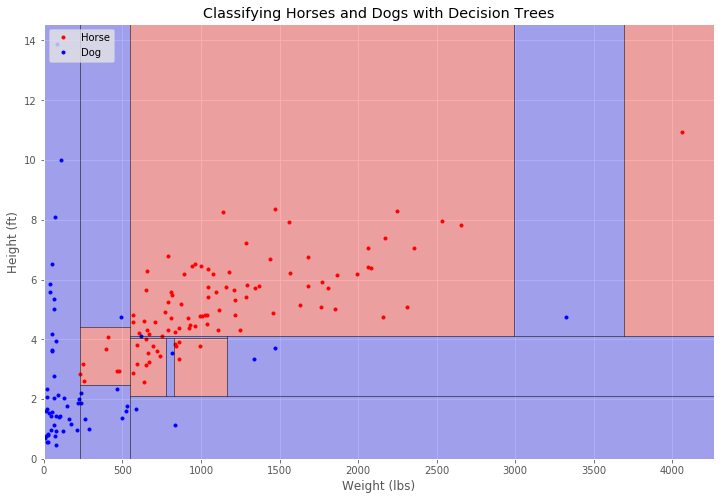

In [33]:
model = tree.DecisionTreeClassifier()
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model)

Clearly there is some risk of overfitting.

## Picking the Best Tree

* Cross validate!
    * Train trees with different parameters, see which performs best on validation set
    * No different than any other model

## Pruning

We call the idea of modifying a decision tree to improve its performance ***pruning***.

There are two approaches: ***pre-pruning*** and ***post-pruning***.

### Pre

Prune as we build the tree, control hyper-parameters

Class discussion: what can we control?

In [34]:
with open('answers/preprune.txt') as f:
    for line in f:
        print(line)

Common Things to Pre-Prune

--------------------------

* Leaf size: stop splitting when num of samples is small enough

* Tree depth: stop splitting at a certain depth

* Purity: stop splitting if purity of leaf nodes hits certain threshold

* Gain Threshold: stop splitting when info gain fails to meet threshold



### Post

Prune after we build the complete tree

* Merge leaves if doing so decreases test-set error

#### Pseudocode
```
function Prune:
    if either left or right is not a leaf:
        call Prune on those that aren't
    if both left and right are (now) leaf nodes:
        calculate error associated with merging two leaf nodes
        calculate error associated without merging two leaf nodes
        if merging results in lower error:
            merge the leaf nodes
```

## Pros and Cons of Decision Trees

Class discussion: what do you think?

In [ ]:
# load answers after class discussion
with open('answers/pc_dt.txt') as f:
    for line in f:
        print(line)

## The Decision Tree Algorithms

There are some famous variants of the decision tree algorithm:

### ID3

Short for Iterative Dichotomiser 3, the original Decision Tree algorithm developed by Ross Quinlan (who's responsible for a lot of proprietary decision tree algorithms) in the 1980's.

* designed for only categorial features
* splits categorical features completely
* uses entropy and information gain to pick the best split

### CART

Short for Classification and Regression Tree was invented about the same time as ID3 by Breiman, Friedman, Olshen and Stone. The CART algorithm has the following properties:

* handles both categorial and continuous data
* always uses binary splits
* uses gini impurity to pick the best split

Algorithms will be called CART even if they don't follow all of the specifications of the original algorithm.

### C4.5

This is Quinlan's first improvement on the ID3 algorithm. The main improvements are:

* handles continuous data
* implements pruning to reduce overfitting

### C5.0

This is supposedly better, but it's proprietary so we don't have access to the specifics of the improvements.